<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finite-horizon-Dynamic-Programming" data-toc-modified-id="Finite-horizon-Dynamic-Programming-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finite-horizon Dynamic Programming</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#The-Big-Picture" data-toc-modified-id="The-Big-Picture-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>The Big Picture</a></span></li></ul></li><li><span><a href="#Exercise-0" data-toc-modified-id="Exercise-0-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exercise 0</a></span></li><li><span><a href="#Answer-0.1" data-toc-modified-id="Answer-0.1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Answer 0.1</a></span></li><li><span><a href="#Answer-0.2" data-toc-modified-id="Answer-0.2-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Answer 0.2</a></span><ul class="toc-item"><li><span><a href="#Throwback" data-toc-modified-id="Throwback-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Throwback</a></span></li></ul></li><li><span><a href="#Self-test-exercise" data-toc-modified-id="Self-test-exercise-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Self-test exercise</a></span></li></ul></li></ul></div>

# Finite-horizon Dynamic Programming

Author: [MachinaFantasma](https://github.com/phantomachine) | [Twitter](https://twitter.com/machinafantasma)


**Key Learning Points**

Ideas:

* From theory (pencil and paper) to code implementation

* Backward induction for finite $T$

Skills/Python:

* 1D Function Approximation and Interpolation
* 1D optimization

Economics:

* Optimal control policy
* Valuation of an optimal program

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as interpolate

### The Big Picture

Consider the problem of choosing a sequence of actions $\mathbf{a} \equiv ( (c_{0}, k_{1}), (c_{1}, k_{2}), ..., (c_{T}, k_{T+1}))$ such that we attain a maximal value:
$$
    V_{T}(k_{0}) = \max_{\mathbf{a}} \left\{ \sum_{t=0}^{T} \beta^{t} U(c_{t}) : k_{t+1} = f(k_{t}) - c_{t}, k_{0} = a \right\},
$$
where $a \in (0,\infty)$ is given, and, $k_{t}$ is a stock of capital fixed at the start of date $t$.

**Avoiding corner and multiplicity of solutions**

The functions $U$ and $f$ are strictly increasing, strictly concave, twice-continuously differentiable and satisfy the usual Inada conditions in our textbooks. 

* The Inada conditions are sufficient to guarantee that optimal solutions live in the interior of the commodity space. 

* Strict convexity of preference set and convexity of production set buys us uniqueness of an optimal solution. 

**Optimal plans**

The necessary (and sufficient) conditions for an optimum are:
$$
    \frac{\beta U_{c}[g_{t+1}(k_{t+1})]}{U_{c}[g_{t}(k_{t})]} = \frac{1}{f_{k}(k_{t+1})};
$$
and, of course, not forgetting that an optimum (or here, equivalently an equilibrium) solution must be feasible:
$$
    k_{t+1} = f(k_{t}) - g_{t}(k_{t}),
$$
for every date $t \in \{0, ...,T\}$.

These say exactly the same thing as what you have learned from microeconomics. (Just relabel $x$ and $y$ to date-$t$ and date-$(t+1)$ contingent goods!)

Note that there are $(T+1)$ number of functions, $(t, k_{t}) \mapsto g_{t}(k_{t})$ for every $t \in \{0, ...,T\}$.

These constitute the sequence of *optimal/equilibrium consumption functions* to be solved for. 

**Economics Takeaway**

* We can think of this problem as a *planner*'s *optimal allocation* (dynamic programming) problem.

* Later when we study *competitive equilibrium* we come back to this example and make some connections, by way of the *Fundamental Welfare Theorems*. (Again, this would be a concept you would have seen from a later-year undergraduate Microeconomics course.)




## Exercise 0

Let $U(c) = \ln(c)$ and $f(k) = k^{\alpha}$, where $\alpha \in (0,1)$. Set $\beta = 1$.

1. Let $T = 2$. Solve for the sequence of value and consumption (demand) *functions* $\left\{ (t, k_{t}) \mapsto g_{t}(k_{t}): t = 0, ...,T \right\}$.

2. Design a pseudocode that reflects what you just did by hand in the last question. (Hint: Can you decipher the source code/methods below and summarize that as an accurate yet human-readable list of instructions?)

2. Implement/write a Python program to solve this example for any value of $T$. Set $\alpha = 0.333$. (The source methods are given to you below.)

In [2]:
# Model primitives

def u(c, θ):
    """Utility function: CRRA class
    
    Note: Theoretically, u'(c) -> \infty when 
    c -> 0 ("in the limit"). Practically, we may 
    have instances where c=0 ("at the limit").
    A small number, say, 1e-18 is added to prevent
    a "division-by-zero" error.
    """
    if θ == 1.0:
        youtiao = np.log(c)
    elif θ > 0.0 and θ != 1.0:
        youtiao = ((c)**(1.0-θ) - 1.0)/(1.0-θ)
    return youtiao

def f(k, α):
    """Cobb-Douglas production function (per capita)"""
    sifan = k**α
    return sifan

def f_prime(k, α):
    """Cobb-Douglas production function (per capita)"""
    return α*k**(α-1.0)

def C_TotalResources(k, knext, α):
    """Resource constraint - returns c, consumption"""
    xiangjiao = f(k, α) - knext
    return xiangjiao

In [3]:
def FunctionFit(X, Y, kind='linear'):
    """Given discrete data (x,y) \in X x Y,
    Find a continuous approximant function f that
    rationalizes finite data. 
    
    Two flavors:
    linear : linear bases
    cubic  : cubic spline
    """
    if kind == 'linear':
        f = interpolate.interp1d(X,Y)
    elif kind == 'cubic':
        f = interpolate.interp1d(X,Y,kind='cubic')
    return f

In [4]:
def Bellman(V_next_fitted, X, α, β, θ):
    """RHS of Bellman equation is a max. problem
    Assumes input V_next_fitted is interpolant object
    - either analytic or SciPy interpolated using
      continuous basis functions
    """
    # Pre-allocate array space
    g = np.empty(X.size)
    h = g.copy()
    V = g.copy()
    
    # Define Objective Function at fixed k
    fungsiobjektif = lambda k_next, k: -u(f(k, α) - k_next, θ) \
                                        - β*V_next_fitted(k_next) 
            
    # Loop over current states in X
    for idx_k, k in enumerate(X):     
        # Solve max. problem to get g(t)(k), V(t)(k)
        k_lb = X.min()
        k_ub = f(k, α)
        knext_opt, val, ierr, numfeval = opt.fminbound(fungsiobjektif, 
                                       k_lb, k_ub, 
                                       args=(k,),
                                       full_output=True,
                                      )
        g[idx_k] = knext_opt
        # Value at optimum, given k
        V[idx_k] = -val
        # Back out c = h(k), store it
        c_opt = C_TotalResources(k, knext_opt, α)
        h[idx_k] = c_opt
        
    # Fitted (interpolants) policy functions
    g_fitted = FunctionFit(X, g, kind='cubic')
    h_fitted = FunctionFit(X, h, kind='cubic')
    V_fitted = FunctionFit(X, V, kind='cubic')
    
    # Bento box
    result = { 'saving': g_fitted,
               'consumption': h_fitted,
               'value': V_fitted,
               'saving-raw': g,
               'consumption-raw': h,
               'value-raw': V,
    }
    return result

In [5]:
def BackwardInduction_Bellman(X, α, β, θ, T=2):
    # Stage T+1 (scrap) value function
    V_next = np.zeros(X.size)
    V_next_fit = FunctionFit(X, V_next)
    V_list = [ V_next_fit ]

    # List containing sequence of policy functions
    g_list = [ ]
    h_list = [ ]

    # Backward induction loop
    for t in range(T, -1, -1):
        # Get optimizers satisfying stage-t Euler functional
        print("Solving Stage t = %i problem" %(t))
        result = Bellman(V_next_fit, X, α, β, θ)
        # Concatenate stage t policies to list of policy functions
        g_list.append(result['saving'])
        h_list.append(result['consumption'])
        V = result['value']
        V_list.append(V)
        # Use current V_t as t-1 stage input
        V_next_fit = V

    # Re-order g_list, h_list by natural time order
    g_list = g_list[::-1] # k(t+1) = g(t)(k(t))
    h_list = h_list[::-1] #   c(t) = h(t)(k(t))
    V_list = V_list[::-1]
    return g_list, h_list, V_list

In [6]:
# Planning horizon
T = 2

# Model parameters
θ = 1.0
α = 0.3333
β = 0.98
A = 1.0

# Discretized state space
N_states = 100
k_min = 1e-12
k_max = (1.0/A)**(1.0/(α-1.0))
X = np.linspace(k_min, k_max, N_states)

## Answer 0.1

Hint: Set $k_{2} = 0$ (Verify why). Use backward induction. The solution is given a by sequence of stage-dependent functions. The outcome (pointwise solution) is characterized by two (second order difference equation in the variable $k$), with the boundary conditions given by the terminal and the initial value of $k$.

## Answer 0.2

Consider the relevant primitive functions for this problem: per-period utility, production or resource constraint functions, state space, action space, discounting.

Now, we solve this by backward induction on the Bellman equation directly. 

In [7]:
g_list, h_list, V_list = BackwardInduction_Bellman(X, α, β, θ, T=2)

Solving Stage t = 2 problem
Solving Stage t = 1 problem
Solving Stage t = 0 problem


### Throwback

Recall the exercise we did and solved by hand?

In [8]:
# Handcrafted solutions (note T = 2 only)

g_0 = (α*β*(1+α*β))*(X**α) / (1+α*β*(1+α*β))
g_1 = α*β*(X**α) / (1+α*β)
g_2 = np.zeros(g_1.size)
g_list_exact = [ g_0, g_1, g_2 ]

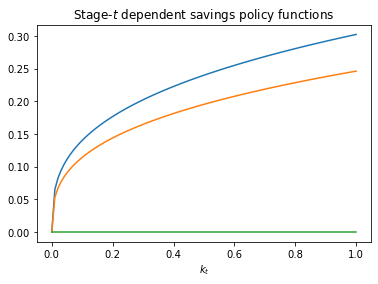

In [9]:
plt.figure()
for t in range(len(g_list_exact)):  
    # Analytical solution
    if θ == 1.0:
        plt.plot(X, g_list_exact[t])
    else:
        print("D'oh! Move along, nothing here to see...")
    plt.xlabel("$k_{t}$")
plt.title("Stage-$t$ dependent savings policy functions")
plt.show() 

Now we will solve the *backward induction* problem directly using the Bellman equation.

We'll compare our numerical results with this plot of the exact decision functions later.

Now we superimpose our backward induction on the Bellman equation solution, onto the analytical solution.

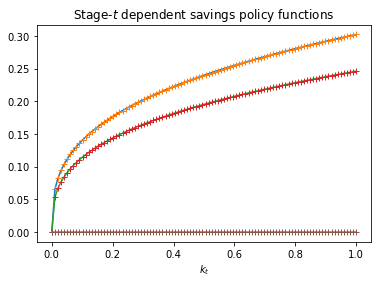

In [10]:
plt.figure()
for t in range(len(g_list)):  
    # Analytical solution
    if θ == 1.0:
        plt.plot(X, g_list_exact[t])
    else:
        print("D'oh! Move along, nothing here to see...")
    # Approximate solution
    plt.plot(X, g_list[t](X), '+',
             label="g("+str(t)+") at $t=$"+str(t)
            )
    plt.xlabel("$k_{t}$")
plt.title("Stage-$t$ dependent savings policy functions")
plt.show() 

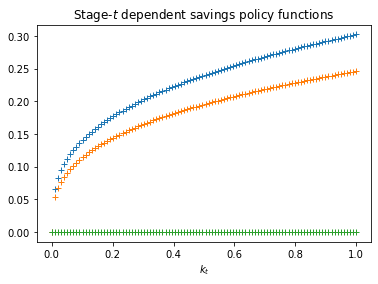

In [11]:
plt.figure()
for t in range(len(g_list)):  
    plt.plot(X, g_list[t](X), '+',
             label="g("+str(t)+") at $t=$"+str(t)
            )
    plt.xlabel("$k_{t}$")
plt.title("Stage-$t$ dependent savings policy functions")
plt.show() 

## Self-test exercise

1. What is the optimal amount of consumption, if at date $t = 1$, the state is $k_{1} = 0.452$?

2. What is the induced indirect utility at this stage-state pair $(t, k_{t}) = (1, 0.452)$?

3. Repeat the solution problem from the start, but now suppose the terminal stage is $T = 120$. Plot the stage-dependent optimal policy and value functions. If the initial state was $k_{0} = 0.25$, what is the optimal path for saving? What is the induced path for indirect utilities at each stage? What is the stage-$0$ indirect utility?

4. Why do we call the value of an optimal plan indirect utility?